## Содержание

[Библиотеки](#libraries)

[1. Данные](#data)

[2. Оценка расстояний](#distance_estimation)
* [Инициализация Triplet Loss моделей](#tl_models_init)
* [Классификаторы ракурса и грузовиков](#additional_classifiers)
* [База признаковых описаний](#feature_base)
* [Метрические классификаторы](#metric_classifiers)
* [Тесты](#tests)
* [Выводы](#conclusion)

<a id='libraries'></a>
## Библиотеки

In [50]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import indexing
from dataset.complement_dataset import complement_dataset

from tools.feature_base import FeaturesBase
from model_test.metric_model_test import test_distance

from models.triplet_loss import TripletLossModel
from models.triplet_loss import ClassificationForTLModel
from models.triplet_loss_old import TripletLossModelOld
from models.triplet_loss_old import conv_simple_features_00
from models.triplet_loss_old import fully_connect_modul_265
import models.metric_tl_classifier as metr_tl_cl

<a id='data'></a>
## 1. Данные

Так как система распознавания работает на основе метрических классификаторов, то с помощью оценки расстояний при распознавании объекта можно оценить, насколько далеко он находится от искомого кластера. Если новый объект в латентном пространстве находится слишком далеко от ближайшего кластера, значит он может быть новым объектом.

Для оценки возможности определения новых объектов в системе на основе расстояний необходимо к тестовой выборке добавить примерно такое же количество изображений, которых не было в тренровочной выборке. На результирующей выборке необходимо изучить значения расстояний для каждого набора изображений.

In [2]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
init_ds_path = os.path.join(datasets_path, '015_model_marka_year_train')
train_ds_path = os.path.join(datasets_path, 'sampled_train_marks_models')
test_ds_path = os.path.join(datasets_path, 'sampled_test')

In [3]:
init_folders = os.listdir(init_ds_path)
init_indexes = indexing.get_indexes(init_folders)

train_folders = os.listdir(test_ds_path)
train_indexes = indexing.get_indexes(train_folders)

test_folders = os.listdir(test_ds_path)
test_indexes = indexing.get_indexes(test_folders)

In [23]:
test_images = []
test_imgs_amount = 0
for fold in test_folders:
    imgs_path = os.path.join(test_ds_path, fold)
    imgs_loc_paths = os.listdir(imgs_path)
    imgs_glob_paths = [os.path.join(imgs_path, ip) for ip in imgs_loc_paths]
    test_images.extend(imgs_glob_paths)
    test_imgs_amount += len(imgs_glob_paths)
    
print(f'Количество изображений в тестовой выборке: {test_imgs_amount}')

Количество изображений в тестовой выборке: 5335


In [5]:
train_marks = set(map(lambda x: x[0], train_indexes))
init_marks = set(map(lambda x: x[0], init_indexes))
new_marks = init_marks - train_marks
print(f'Количество не использованных в обучении марок: {len(new_marks)}')

Количество не использованных в обучении марок: 122


In [8]:
new_imgs_amount = 5335
new_images, new_indexes = complement_dataset(init_ds_path,
                                             new_marks,
                                             new_imgs_amount,
                                             random_state=0)

<a id='distance_estimation'></a>
## 2. Оценка расстояний

<a id='tl_models_init'></a>
**Инициализация Triplet Loss моделей**

In [16]:
marks_features_len = 128
tl_mark_model = TripletLossModel(marks_features_len)

weights_marks_p = [
    'weights/2. triplet loss model - marks/3. 1154 epochs/conv2Dfeatures_best_var.pt',
    'weights/2. triplet loss model - marks/3. 1154 epochs/fully_connect_best_var.pt'
]

tl_mark_model.split_load(weights_marks_p)

In [17]:
IMAGE_SIZE = [128, 128, 1] 
device = 'cpu'
tl_models_old_model = TripletLossModelOld(
    conv_simple_features_00,
    fully_connect_modul_265,
    IMAGE_SIZE, device=device)

weights_paths = [
    'weights/4. triplet loss model - models/3. trained old/conv2Dfeatures.pt',
    'weights/4. triplet loss model - models/3. trained old/fully_connect.pt'    
]

tl_models_old_model.conv_block.load_state(weights_paths[0],
                                          map_location=device)
tl_models_old_model.fc_block.load_state(weights_paths[1],
                                        map_location=device)


Loading preset weights... Ok.

Loading preset weights... Ok.


<a id='additional_classifiers'></a>
**Классификаторы ракурса и грузовиков**

In [18]:
class_view_model = ClassificationForTLModel(2)
weights_p = 'weights/5. view classifier/classif_model_weights_maxAccuracy.pt'
class_view_model.load_state(weights_p)

class_truck_model = ClassificationForTLModel(2)
weights_p = 'weights/6. truck classifier/classif_model_weights_maxAccuracy.pt'
class_truck_model.load_state(weights_p)

<a id='feature_base'></a>
**База признаковых описаний**

In [19]:
total_features_len = 192
features_base_joint = FeaturesBase(total_features_len)

base_filepaths = [
    'csv/train/data_marks_train_joint.csv',
    'csv/train/data_models_train_joint.csv',
    'csv/train/data_all_train_joint.csv'
]

features_base_joint.load_base(base_filepaths)

<a id='metric_classifiers'></a>
**Метрические классификаторы**

Метрическая модель:

In [20]:
mah_marks_model = metr_tl_cl.MarksMah(features_base_joint,
                                      keys=['View', 'Truck'])
mah_marks_model.set_mah()

knn_models_model = metr_tl_cl.ModelskNN(features_base_joint)
knn_models_model.set_knn()


mah_knn_model = metr_tl_cl.MetricClassificationModel(
    mah_marks_model,
    knn_models_model
)

<a id='tests'></a>
**Тесты**

In [25]:
test_marks_dist, test_models_dist = test_distance(
    test_images, tl_mark_model, tl_models_old_model,
    mah_knn_model, class_view_model, class_truck_model)

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

In [26]:
new_marks_dist, new_models_dist = test_distance(
    new_images, tl_mark_model, tl_models_old_model,
    mah_knn_model, class_view_model, class_truck_model)

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

  0%|          | 0/5335 [00:00<?, ?it/s]

Для оценки различия в расстояниях между новыми и старыми для системы объектами, построим ядерные оценки плотности распределений расстояний.

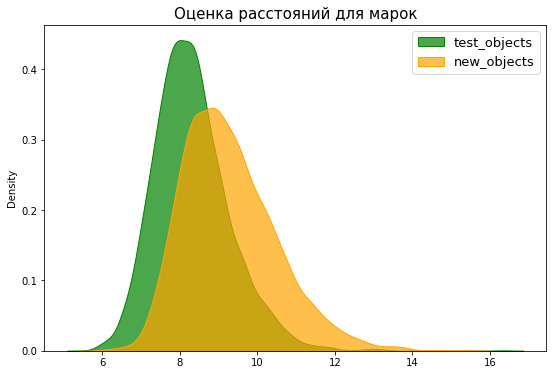


Среднее расстояние для марок:
test: 8.31
new:  9.276

Медианное расстояние для марок:
test: 8.215
new:  9.107


In [51]:
plt.figure(figsize=(9,6))
sns.kdeplot(test_marks_dist, shade=True, color='green',
            label='test_objects', alpha=.7)
sns.kdeplot(new_marks_dist, shade=True, color='orange',
            label='new_objects', alpha=.7)
plt.title('Оценка расстояний для марок', fontsize=15)
plt.legend(fontsize=13)
plt.show()

print('\nСреднее расстояние для марок:')
test_mark_mean_dist = round(test_marks_dist.mean(), 3)
print(f'test: {test_mark_mean_dist}')
new_mark_mean_dist = round(new_marks_dist.mean(), 3)
print(f'new:  {new_mark_mean_dist}')

print('\nМедианное расстояние для марок:')
test_mark_median_dist = round(np.median(test_marks_dist), 3)
print(f'test: {test_mark_median_dist}')
new_mark_median_dist = round(np.median(new_marks_dist), 3)
print(f'new:  {new_mark_median_dist}')

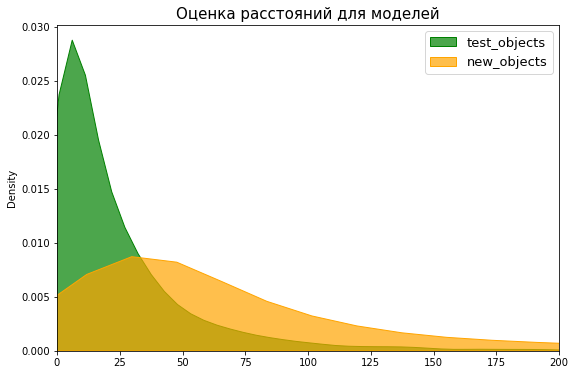


Среднее расстояние для моделей:
test: 24.03
new:  80.58

Медианное расстояние для моделей:
test: 24.03
new:  44.497


In [67]:
plt.figure(figsize=(9,6))
sns.kdeplot(test_models_dist, shade=True, color='green',
            label='test_objects', alpha=.7)
sns.kdeplot(new_models_dist, shade=True, color='orange',
            label='new_objects', alpha=.7)
plt.title('Оценка расстояний для моделей', fontsize=15)
plt.legend(fontsize=13)
plt.xlim(0, 200)
plt.show()

print('\nСреднее расстояние для моделей:')
test_models_mean_dist = round(test_models_dist.mean(), 3)
print('test: ' + str(test_models_mean_dist))
new_models_mean_dist = round(new_models_dist.mean(), 3)
print('new:  ' + str(new_models_mean_dist))

print('\nМедианное расстояние для моделей:')
test_models_median_dist = round(np.median(test_models_dist), 3)
print('test: ' + str(test_models_mean_dist))
new_models_median_dist = round(np.median(new_models_dist), 3)
print(f'new:  ' + str(new_models_median_dist)) 

<a id='conclusion'></a>
**Выводы**

Если рассматривать результаты по маркам, то видно, что гистограммы не так далеко друг от друга, как, возможно, хотелось бы. Однако в случае моделей ситуация обстоит хоть и немного, но лучше. В случае моделей новые объекты формируют достаточно тяжелый хвост справа, что сильно смещает как среднее, так и медианное значения от тех же значений по объектам тестовой выборки. Это все же позволяет с некоторой точностью реализовывать систему обнаружения новых объектов используя как и чисто значения по маркам или моделям, так и их взешенные комбинации, переходя ближе к неким дополнительным эвристикам оценки объекта как нового.

Также стоит отметить, что при необходимости часть дополнительной работы может быть направлена на повышение уровня устойчивости дескрипторов, тем более идей их развития достаточно много, что в результате может дать убедительное качество.